In [1]:
#!/usr/bin/env python
import os
import json
import numpy as np
import pandas as pd

from cmdstanpy import CmdStanModel, write_stan_json
from notebook_helpers import set_formats, gen_data, summary_by_var

import plotnine as p9
# setup plotnine look and feel
p9.theme_set(
  p9.theme_grey() + 
  p9.theme(text=p9.element_text(size=10),
        plot_title=p9.element_text(size=14),
        axis_title_x=p9.element_text(size=12),
        axis_title_y=p9.element_text(size=12),
        axis_text_x=p9.element_text(size=8),
        axis_text_y=p9.element_text(size=8)
       )
)
xlabels_90 = p9.theme(axis_text_x = p9.element_text(angle=90, hjust=1))

In [2]:
set_formats(2, 100)

### Posterior predictive check

Posterior predictive checking can be done in tandem with model fitting
if the model's `generated quantities` block defines variable `y_rep`.
For the example linear model,  modeled data variable `y` is declared
```
vector[N] y;
```
and the likelihood is:
```
y ~ normal(alpha + beta * x, sigma)
```

Therefore, in the `generated quantities` block, we define `y_rep`:
```
array[N] real y_rep = normal_rng(alpha + beta * x, sigma);
```

In [3]:
with open('linear_data.json', 'r') as file:
    linear_data = json.load(file)

In [4]:
linear_model = CmdStanModel(stan_file="linear_model.stan");
lm_fit = linear_model.sample(data=linear_data)

17:51:07 - cmdstanpy - INFO - compiling stan file /Users/mitzi/github/zmorris/epistan/sim_studies/linear_model.stan to exe file /Users/mitzi/github/zmorris/epistan/sim_studies/linear_model
17:51:10 - cmdstanpy - INFO - compiled model executable: /Users/mitzi/github/zmorris/epistan/sim_studies/linear_model
17:51:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:51:10 - cmdstanpy - INFO - CmdStan done processing.
17:51:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'linear_model.stan', line 15, column 2 to column 38)
Consider re-running with show_console=True if the above output is unclear!


In [5]:
lm_fit.summary()[:4]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,55.31,0.03,1.27,52.85,55.66,56.66,1942.91,15668.60,1.00
alpha,-1.36,0.00,0.04,-1.41,-1.36,-1.30,3145.75,25369.00,1.00
beta,0.29,0.00,0.01,0.27,0.29,0.31,3890.49,31374.90,1.00
sigma,0.35,0.00,0.03,0.31,0.34,0.39,3140.98,25330.50,1.00


Compare observed `y` to summary statistics of `y_rep` using ggplot2 (plotnine) boxplot of the simlicated vs raw data.

In [6]:
# this is the critical call to cmdstanpy
y_rep_pd = lm_fit.draws_pd(vars='y_rep')

# the rest is data-munging for plotnine
true_y = {col: linear_data['y'][i] for i, col in enumerate(y_rep_pd.columns)}
y_rep_long = y_rep_pd.melt(var_name='y_rep', value_name='value')
y_rep_long['y'] = y_rep_long['y_rep'].map(true_y)
y_rep_long.head()

,y_rep,value,y
0,y_rep[1],-1.79,-1.33
1,y_rep[1],-1.85,-1.33
2,y_rep[1],-1.92,-1.33
3,y_rep[1],-1.82,-1.33
4,y_rep[1],-1.64,-1.33


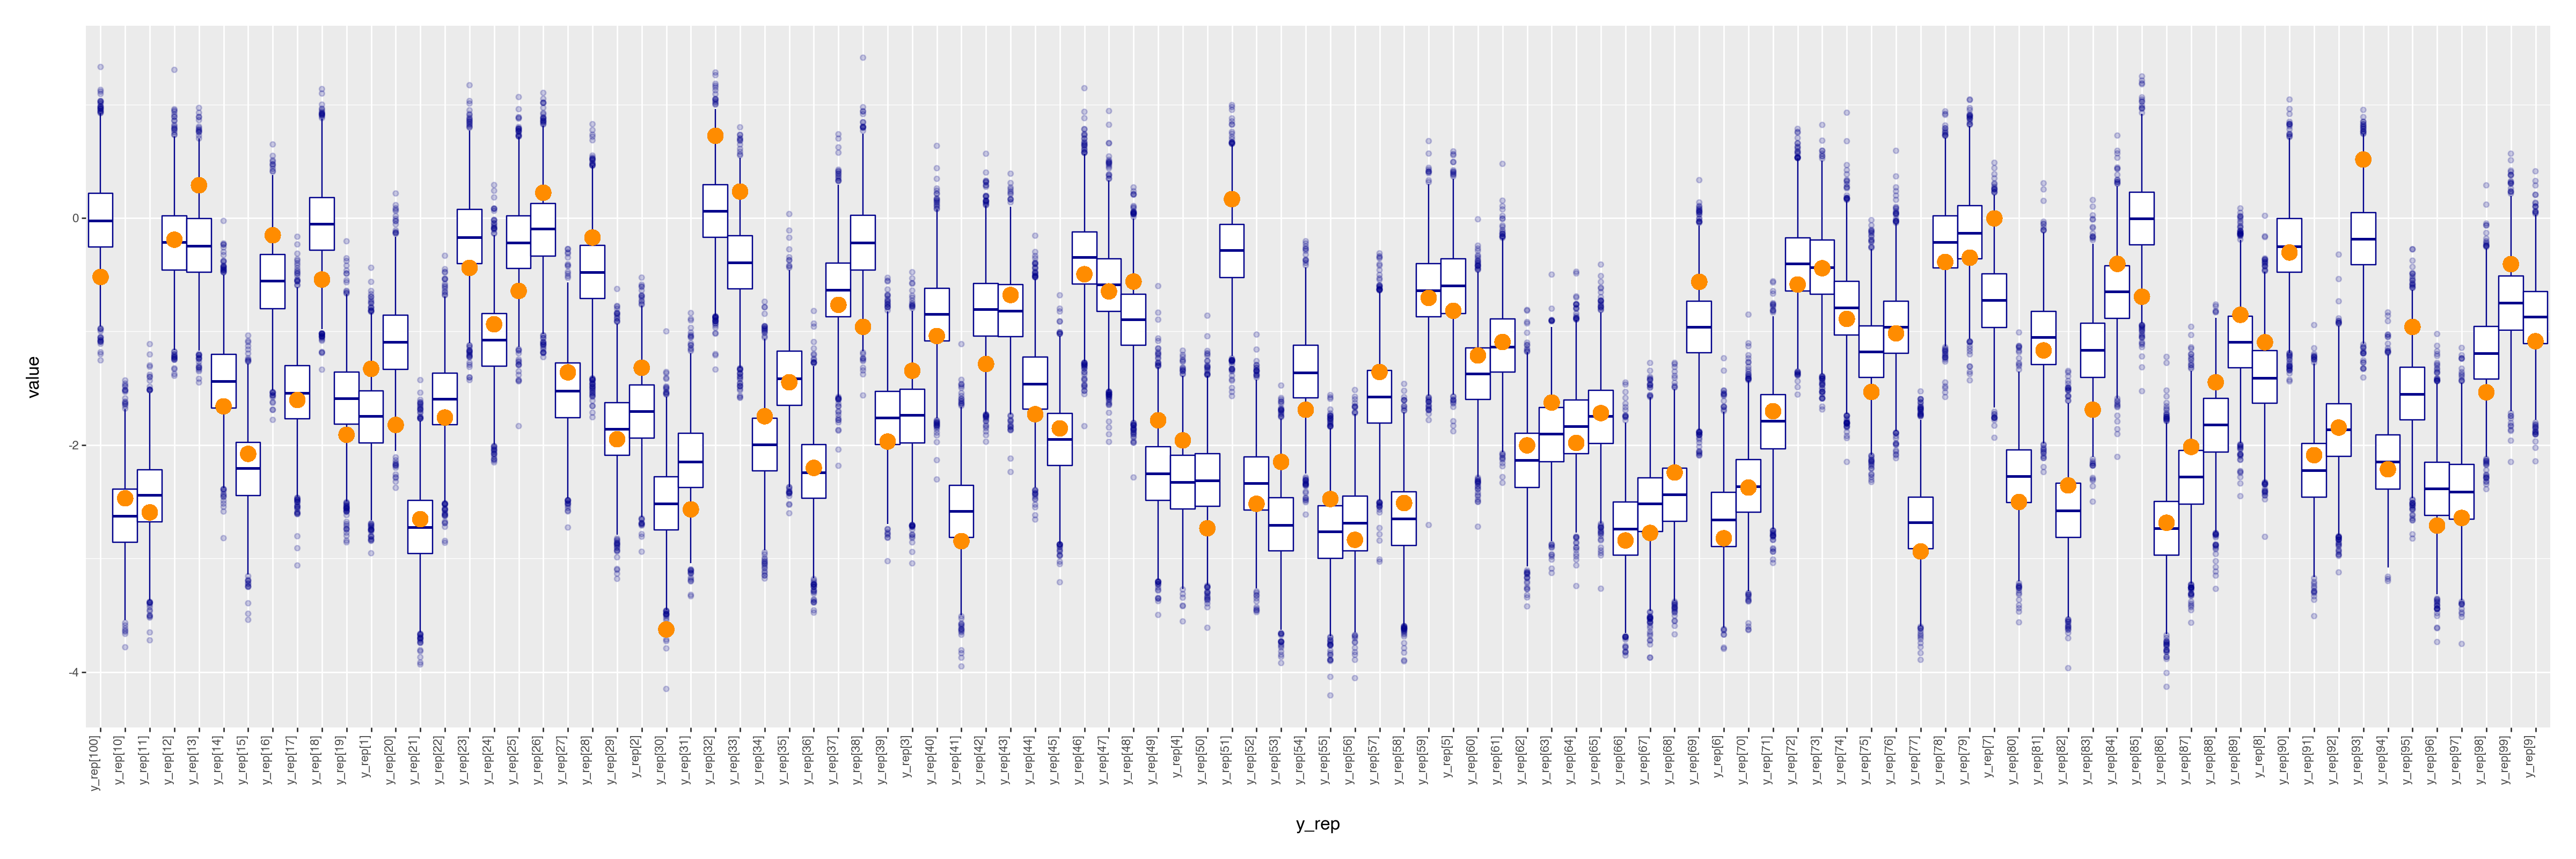

In [7]:
# with only 100 data points, we can visualize the per-data-point predictions
(p9.ggplot(data=y_rep_long, mapping=p9.aes(x='y_rep',y='value'))
    + p9.geom_boxplot(width=1, outlier_alpha=0.2, color='darkblue')
    + p9.geom_point(p9.aes(y='y'), color='darkorange', size=5)
    + xlabels_90
    + p9.theme(figure_size=(24,8))
)

Another visualization is to plot the distribution of the actual data against a random sample of replicates. We plot 2% of the data - 80 replicates out of 4000.

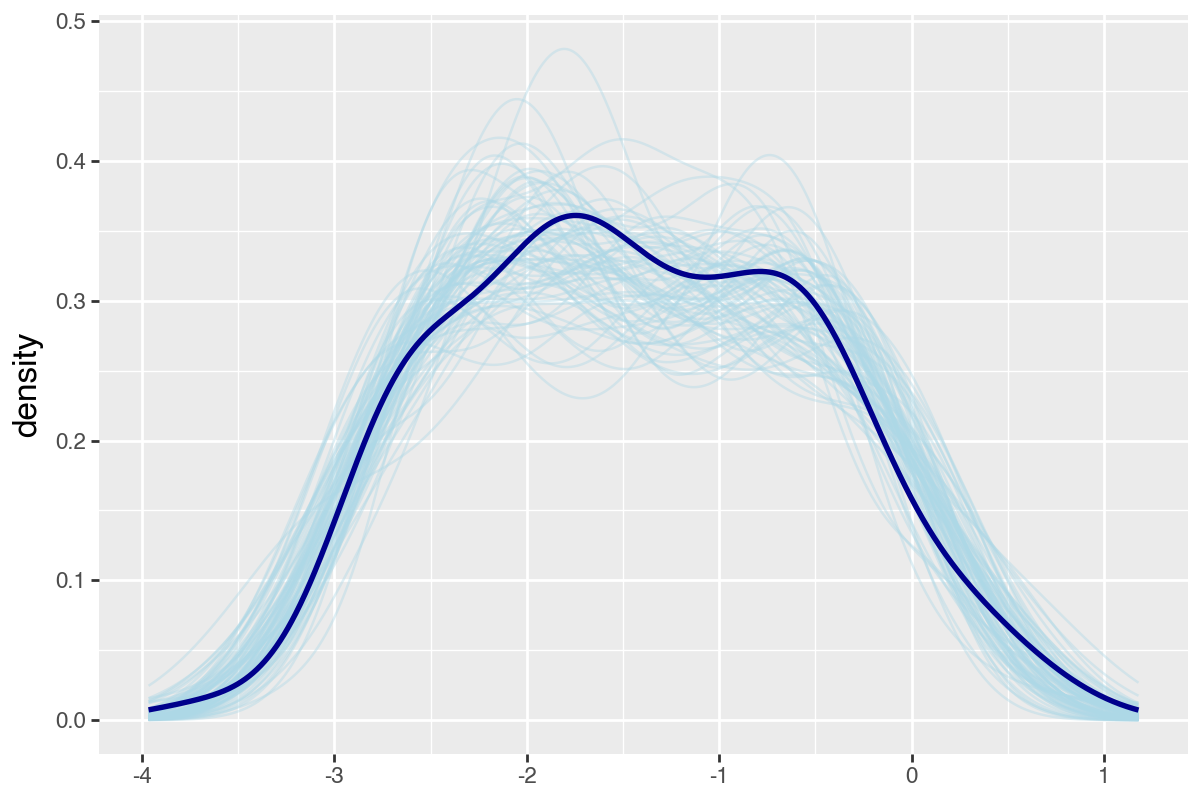

In [8]:
sz = 80
y_rep_sample = y_rep_pd.sample(sz).reset_index(drop=True).T
dens_plot = p9.ggplot()
for i in range(sz):
    dens_plot = dens_plot + p9.stat_density(mapping=p9.aes(x=y_rep_sample[i]), geom='line', color='lightblue', alpha=0.4)
dens_plot = (dens_plot
          + p9.stat_density(mapping=p9.aes(linear_data['y']), geom='line', color='darkblue', size=1.1)
          + p9.theme(figure_size=(6,4))
         )   
dens_plot

### Prior predictive check

The model in the previous section, file `linear_model.stan` has a corresponding data-generating program `linear_model_dgp.stan`.

Note:  naming files is hard.  Here we adopt the convenction of adding suffix `_dgp` to keep files lined up.

```stan
data {
  int<lower=0> N;
}
generated quantities {
  real alpha_sim = normal_rng(0, 2);
  real beta_sim = normal_rng(0, 1);
  real sigma_sim = abs(normal_rng(0, 1));
  vector[N] x_sim;
  for (n in 1:N) {
    x_sim[n]  = uniform_rng(-5, 5);
  }
  array[N] real y_sim = normal_rng(alpha_sim + beta_sim * x_sim, sigma_sim);
}
```

In [9]:
linear_model_dgp = CmdStanModel(stan_file="linear_model_dgp.stan");
dgp_fit = linear_model_dgp.sample(data=linear_data)

17:51:25 - cmdstanpy - INFO - compiling stan file /Users/mitzi/github/zmorris/epistan/sim_studies/linear_model_dgp.stan to exe file /Users/mitzi/github/zmorris/epistan/sim_studies/linear_model_dgp
17:51:27 - cmdstanpy - INFO - compiled model executable: /Users/mitzi/github/zmorris/epistan/sim_studies/linear_model_dgp
17:51:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:51:28 - cmdstanpy - INFO - CmdStan done processing.


In [10]:
dgp_fit.summary()[:3]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha_sim,-0.01,0.03,2.00,-3.32,0.02,3.26,4002.64,19717.50,1.00
beta_sim,0.00,0.02,0.99,-1.64,-0.01,1.64,3998.92,19699.10,1.00
sigma_sim,0.80,0.01,0.60,0.06,0.68,1.93,3993.82,19674.00,1.00


The key challenge in working with Stan output is understanding how to get the information you want out of the returned fit object in the format you need.

For plotting using ggplot2 (plotnine), the data should be in a DataFrame.

In [11]:
y_sim_pd = dgp_fit.draws_pd(vars='y_sim')

The rest is data-munging and plotting.

In [ ]:
y_sim_long = y_sim_pd.melt(var_name='y_sim', value_name='value')
true_y = {col: linear_data['y'][i] for i, col in enumerate(y_sim_pd.columns)}
y_sim_long['y'] = y_sim_long['y_sim'].map(true_y)
y_sim_long.head()  # check your work

sz = 80  # plot 2% of the data - 4000 draws
y_sim_sample = y_sim_pd.sample(sz).reset_index(drop=True).T
dens_plot = p9.ggplot()
for i in range(sz):
    dens_plot = dens_plot + p9.stat_density(mapping=p9.aes(x=y_sim_sample[i]), geom='line', color='lightblue', alpha=0.4)
dens_plot = (dens_plot
          + p9.stat_density(mapping=p9.aes(linear_data['y']), geom='line', color='darkblue', size=1.1)
          + p9.theme(figure_size=(6,4))
         )   
dens_plot

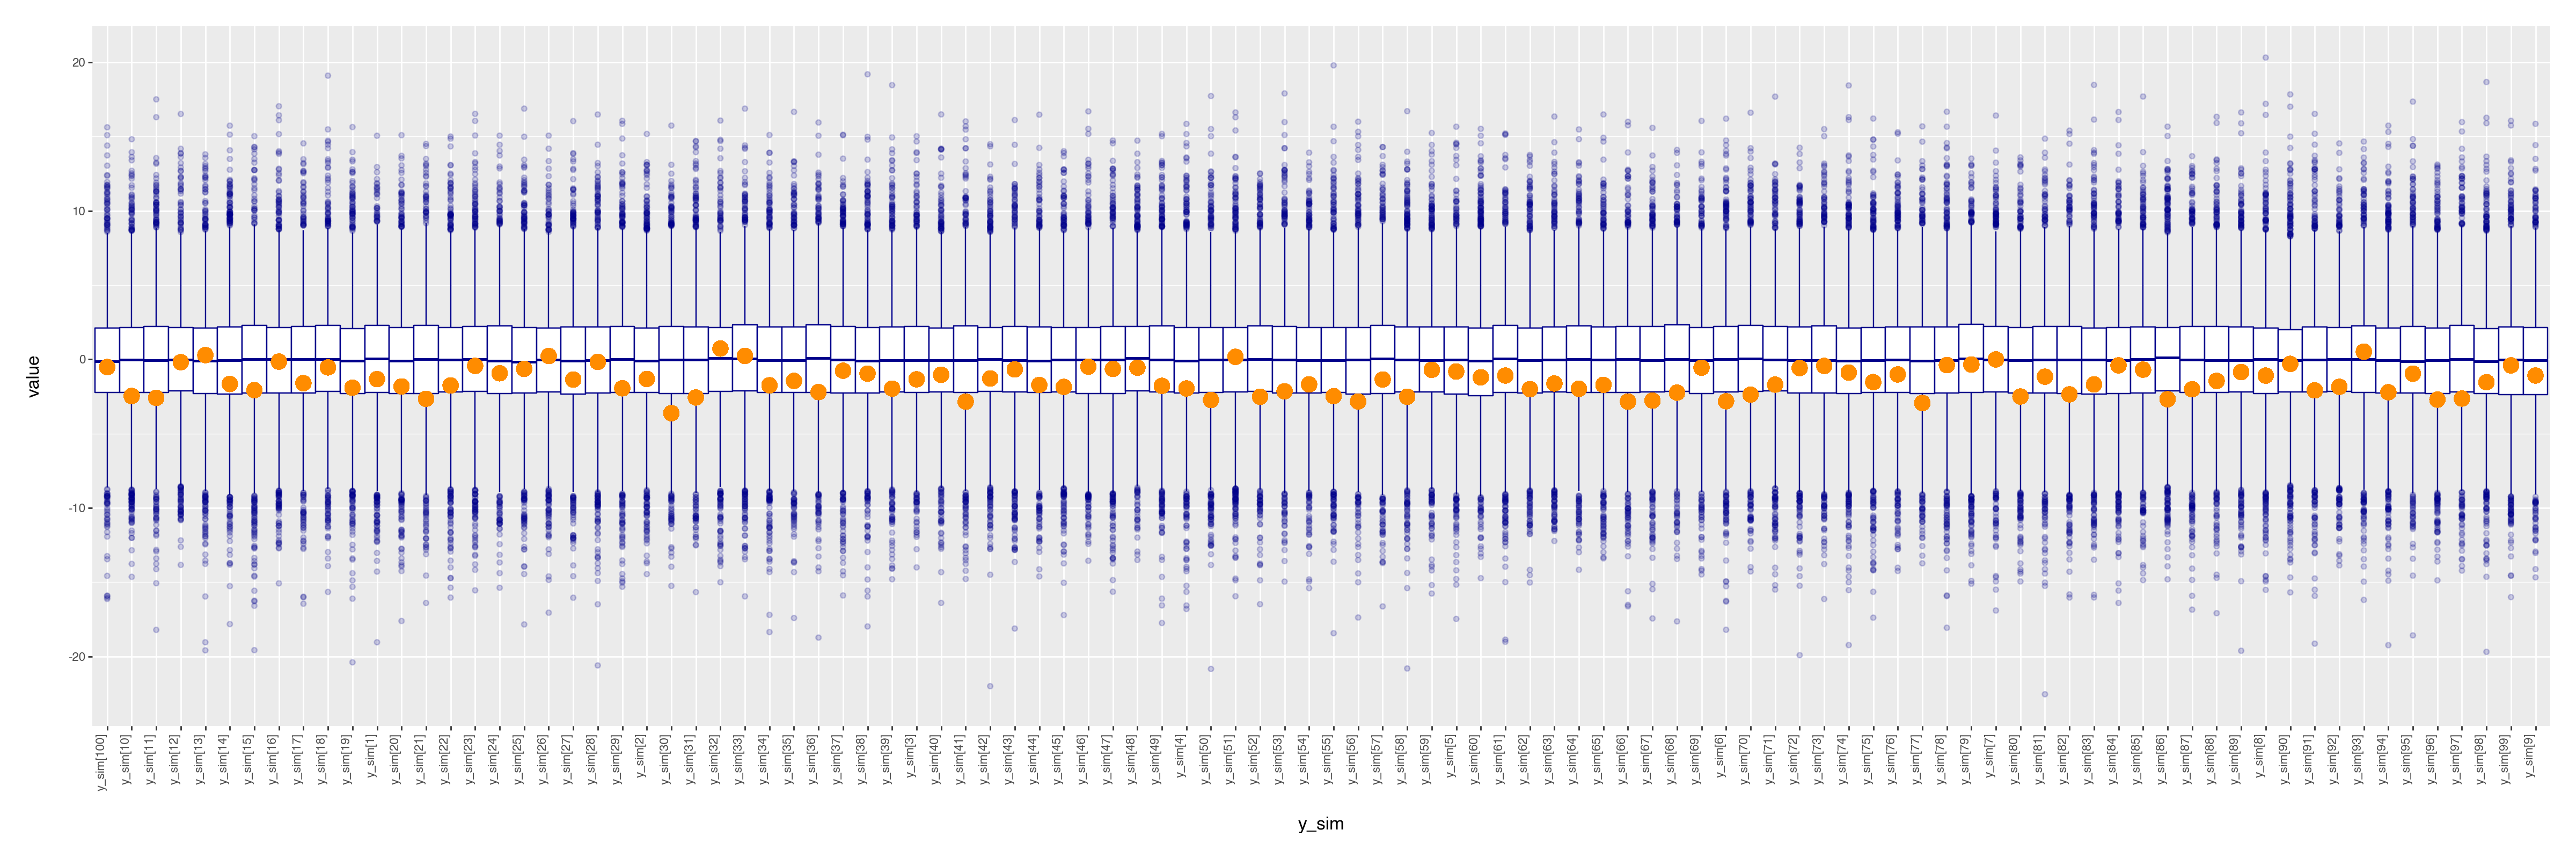

In [16]:
# with only 100 data points, we can visualize the per-data-point predictions
(p9.ggplot(data=y_sim_long, mapping=p9.aes(x='y_sim',y='value'))
    + p9.geom_boxplot(width=1, outlier_alpha=0.2, color='darkblue')
    + p9.geom_point(p9.aes(y='y'), color='darkorange', size=5)
    + xlabels_90
    + p9.theme(figure_size=(24,8))
)

Visualize priors against linear_data['x'] - which was generated from one draw from this program.

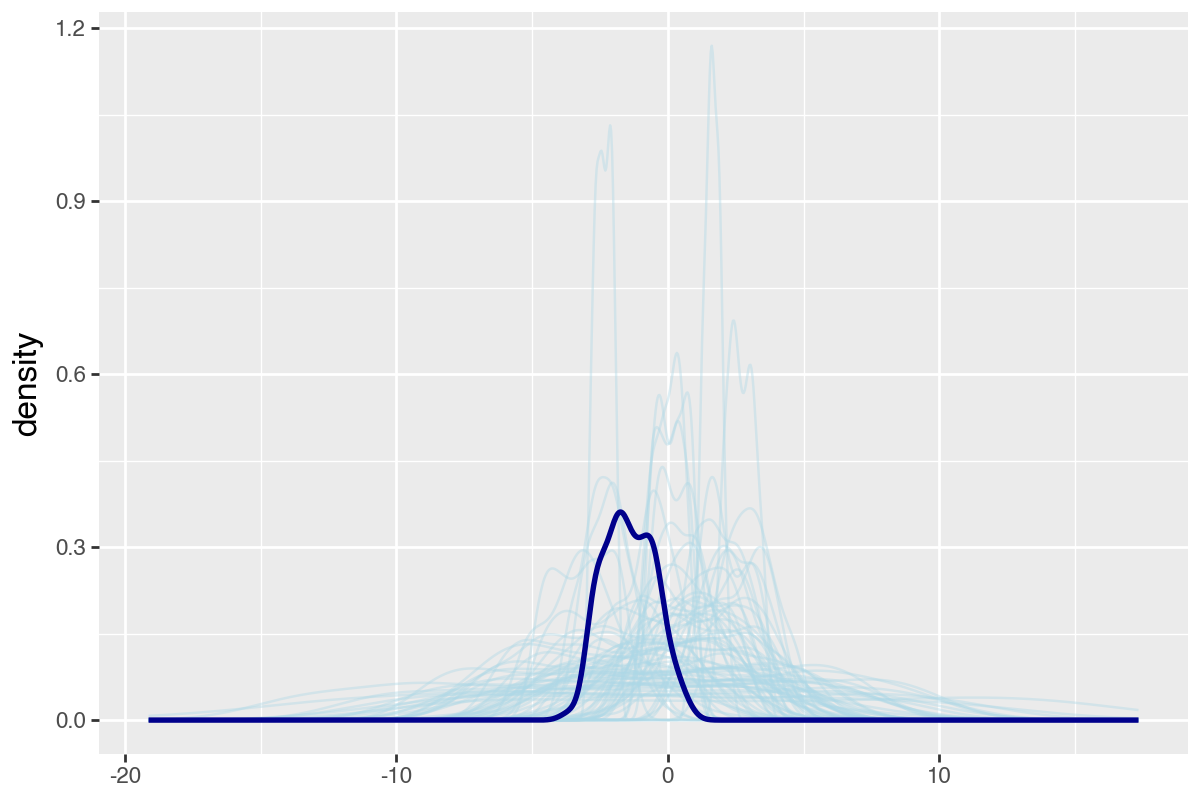

In [14]:
y_sim_x_pd = dgp_fit.draws_pd(vars='y_sim_x')

y_sim_x_long = y_sim_x_pd.melt(var_name='y_sim_x', value_name='value')
true_y = {col: linear_data['y'][i] for i, col in enumerate(y_sim_x_pd.columns)}
y_sim_x_long['y'] = y_sim_x_long['y_sim_x'].map(true_y)
y_sim_x_long.head()  # check your work

sz = 80  # plot 2% of the data - 4000 draws
y_sim_x_sample = y_sim_x_pd.sample(sz).reset_index(drop=True).T
dens_plot = p9.ggplot()
for i in range(sz):
    dens_plot = dens_plot + p9.stat_density(mapping=p9.aes(x=y_sim_x_sample[i]), geom='line', color='lightblue', alpha=0.4)
dens_plot = (dens_plot
          + p9.stat_density(mapping=p9.aes(linear_data['y']), geom='line', color='darkblue', size=1.1)
          + p9.theme(figure_size=(6,4))
         )   
dens_plot

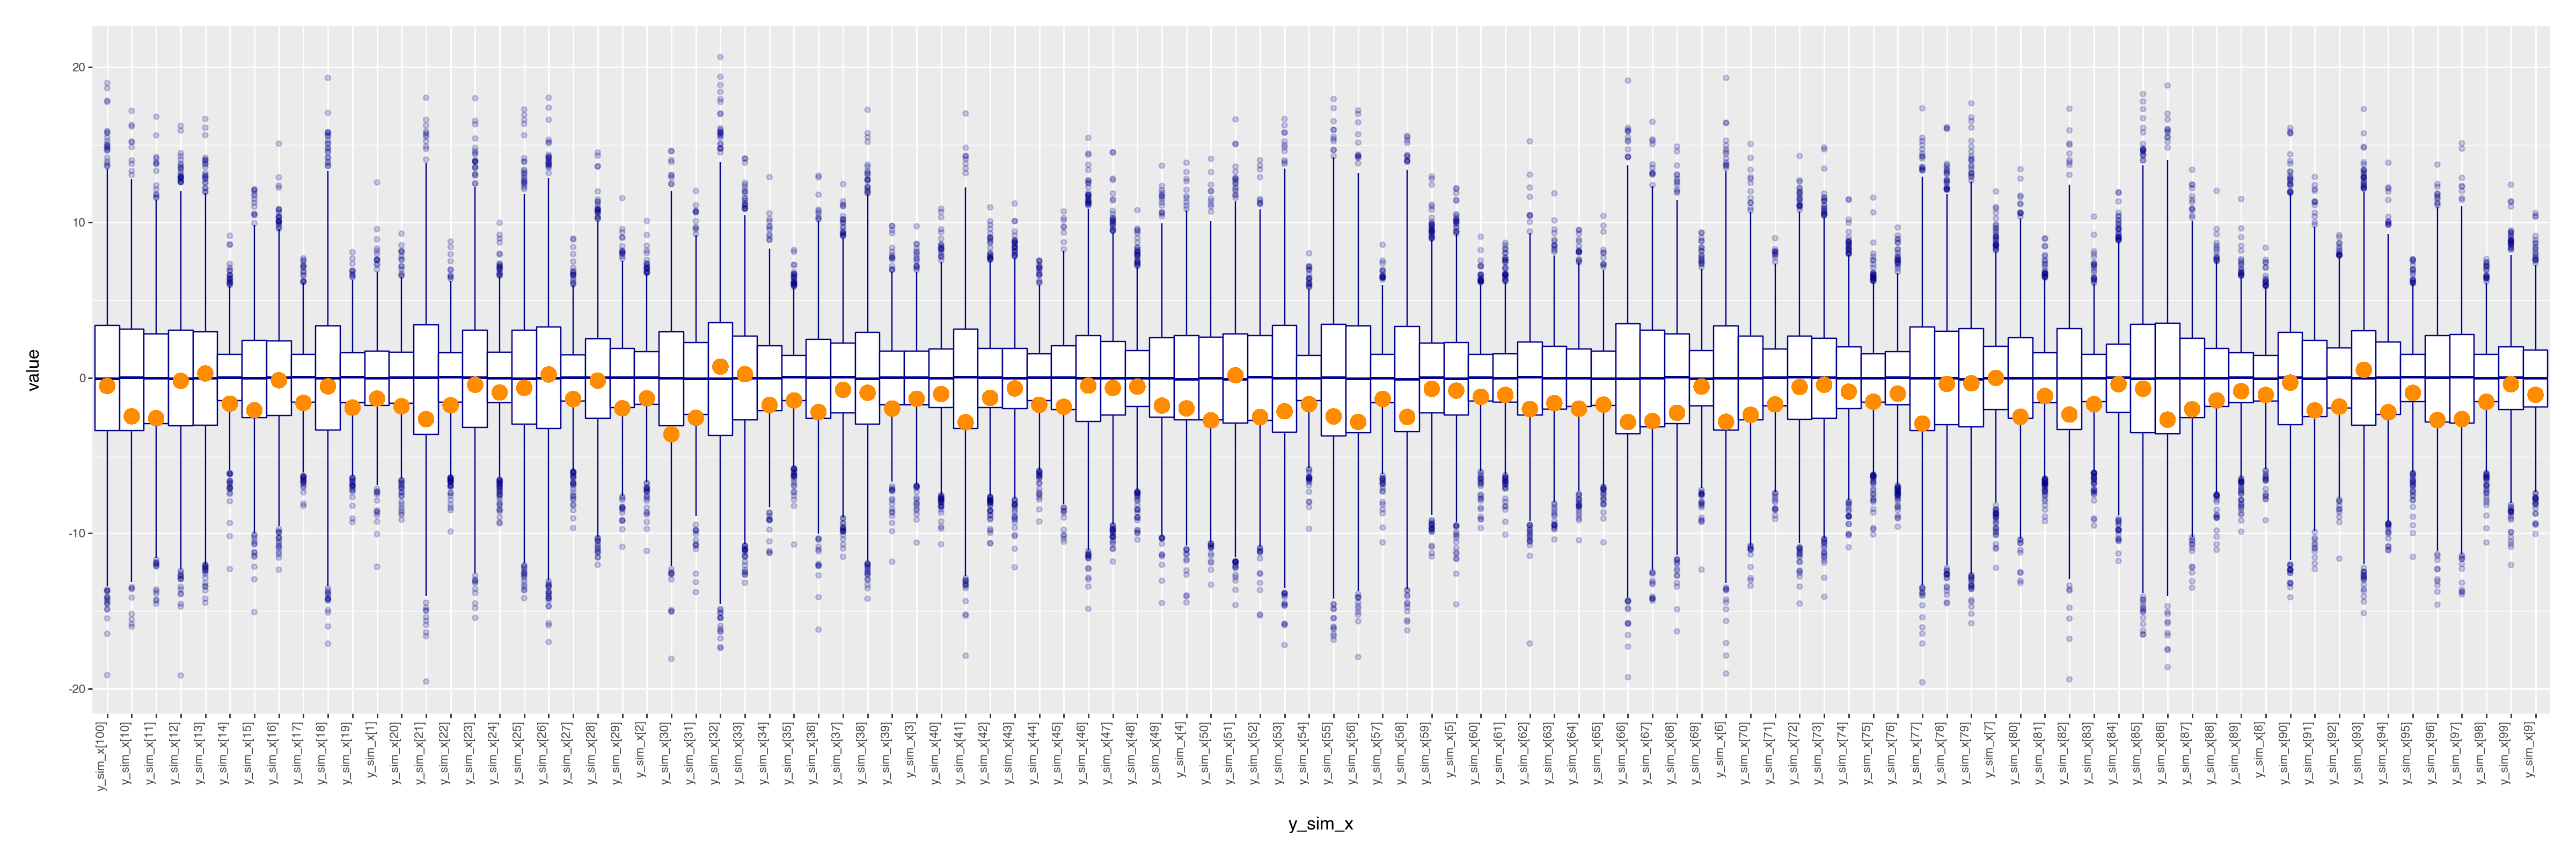

In [15]:
(p9.ggplot(data=y_sim_x_long, mapping=p9.aes(x='y_sim_x',y='value'))
    + p9.geom_boxplot(width=1, outlier_alpha=0.2, color='darkblue')
    + p9.geom_point(p9.aes(y='y'), color='darkorange', size=5)
    + xlabels_90
    + p9.theme(figure_size=(24,8))
)